In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
# Read the data
df=pd.read_csv('data/transactions_processed.csv',parse_dates=['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange'])

# Detection and Removal of Reversed Transactions

#### After manual inspection of a few instances of Purchase followed by a Reversal, I noticed the following points:
1. All of the columns except for transactionDateTime, AvailableMoney, currentBalance and TransactionType will remain the same for a purchased transaction that is reversed.
2. In some cases, a revered transaction does not occur immediately. We will need to ignore that case for now.

#### Based on these observations, my approach to remove duplicates will be as follows:

Method 1:
1. Looking at pairs of transactions where all parameters are same except transactionDateTime, AvailableMoney, currentBalance, and TransactionType. TransactionType=PURCHASE should be followed by TransactionType=REVERSED.
2. This should lead to a pandas dataframe with label imbalance ratio to be similar to the original label imbalance ratio.

The assumption in this case is that 2 PURCHASES of the same amount from the same customer to the same merchant do not follow each other 

In [132]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [133]:
len(df)

786363

In [134]:
# First let us seperately store the instances of Transaction_Type as 'ADDRESS_VERIFICATION'
df2=df[df['transactionType']=='ADDRESS_VERIFICATION']
# Remove address verification transactions from the original dataframe  and store it in df1
df1=df[df['transactionType']!='ADDRESS_VERIFICATION']
cols=df.columns.tolist()
col_rem=['transactionDateTime','AvailableMoney','currentBalance','TransactionType']
col_take=[i for i in cols if i not in col_rem]
df1=df1.drop_duplicates(subset=col_take,keep='first')
df3=pd.concat([df1,df2],axis=0)
df3['isFraud'].value_counts()

False    769332
True      12416
Name: isFraud, dtype: int64

In [135]:
len(df3)

781748

In [136]:
df['transactionAmount'].sum()-df3['transactionAmount'].sum()

108389.23999996483

This caused a reduction in the number of cases from 786363 to 781748. The label imbalance changed from 62.32:1 to 61.96:1

So the number of transactions this method estimated were reversed was 4,615 and the total amount I estimate for reversed transactions is about $108,389.239.

Method 2: There is a more crude duplicate which just notices the same amount between the same Customer ID, Merchant, one of which is a purchase and the other being a reversal (in case I am missing a trend). So, let's do that as well. 

In [137]:
df4=df[df['transactionType']!='ADDRESS_VERIFICATION']
df5=df4.drop_duplicates(subset=['customerId','transactionAmount', 'merchantName', 'acqCountry'],keep='first')
df6=pd.concat([df5,df2],axis=0)
df6['isFraud'].value_counts()

False    705842
True      11939
Name: isFraud, dtype: int64

In [138]:
len(df6)

717781

In [139]:
df['transactionAmount'].sum()-df6['transactionAmount'].sum()

5028227.269999981

This caused a reduction in the number of cases from 786363 to 717781. The label imbalance changed from 62.32:1 to 59.12:1. 

So the number of transactions this method estimated were reversed was 68,582 and the total amount I estimate for reversed transactions is about $5,028,227.269

As this instance caused the label imbalance to be comparatively lesser, we would prefer this data for our modelling purposes. However, we will keep the data from earlier method as well as the query of that method seems more granular.

In [140]:
df3.to_csv('data/transactions_processed_noreversed_method1.csv',index=False)

In [141]:
df6.to_csv('data/transactions_processed_noreversed_method2.csv',index=False)

# Detection and Removal of Multi-Swipe Transactions

#### I plan to tackle this problem in the following way:
1. Sort the whole dataframe by CustomerID,TransactionDateTime
2. Then we can use group by operation in CustomerID, MerchantName, TransactionAmount 
3. Then check if the time difference between successive Transactions is less than t seconds

Idea from https://stackoverflow.com/questions/56517004/mark-duplicates-based-on-time-difference-between-successive-rows

In [142]:
df['transactionDateTime']=pd.to_datetime(df['transactionDateTime'])

#### In this section, we have tried to check various time periods between transactions. Namely, we tested times (in minutes):
1. t<=1
2. t<=2
3. t<=3
4. t<=4
5. t<=5
6. t<=6
7. t<=7
8. t<=8
9. t<=9
10. t<=10 

In [143]:
df.sort_values(by=['customerId','transactionDateTime'],inplace=True)
# Set a time window for identifying multi-swipe transactions (adjust as needed)
time_window1 = pd.Timedelta(minutes=1)
time_window2 = pd.Timedelta(minutes=2)
time_window3 = pd.Timedelta(minutes=3)
time_window4 = pd.Timedelta(minutes=4)
time_window5 = pd.Timedelta(minutes=5)
time_window6 = pd.Timedelta(minutes=6)
time_window7 = pd.Timedelta(minutes=7)
time_window8 = pd.Timedelta(minutes=8)
time_window9 = pd.Timedelta(minutes=9)
time_window10 = pd.Timedelta(minutes=10)
multi_swipe_transactions = df[(df.duplicated(subset=['transactionAmount', 'merchantName', 'customerId'], keep=False))]
multi_swipe_transactions_1 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window1]
multi_swipe_transactions_2 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window2]
multi_swipe_transactions_3 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window3]
multi_swipe_transactions_4 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window4]
multi_swipe_transactions_5 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window5]
multi_swipe_transactions_6 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window6]
multi_swipe_transactions_7 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window7]
multi_swipe_transactions_8 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window8]
multi_swipe_transactions_9 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window9]
multi_swipe_transactions_10 = multi_swipe_transactions[multi_swipe_transactions['transactionDateTime'] - multi_swipe_transactions['transactionDateTime'].shift() <= time_window10]

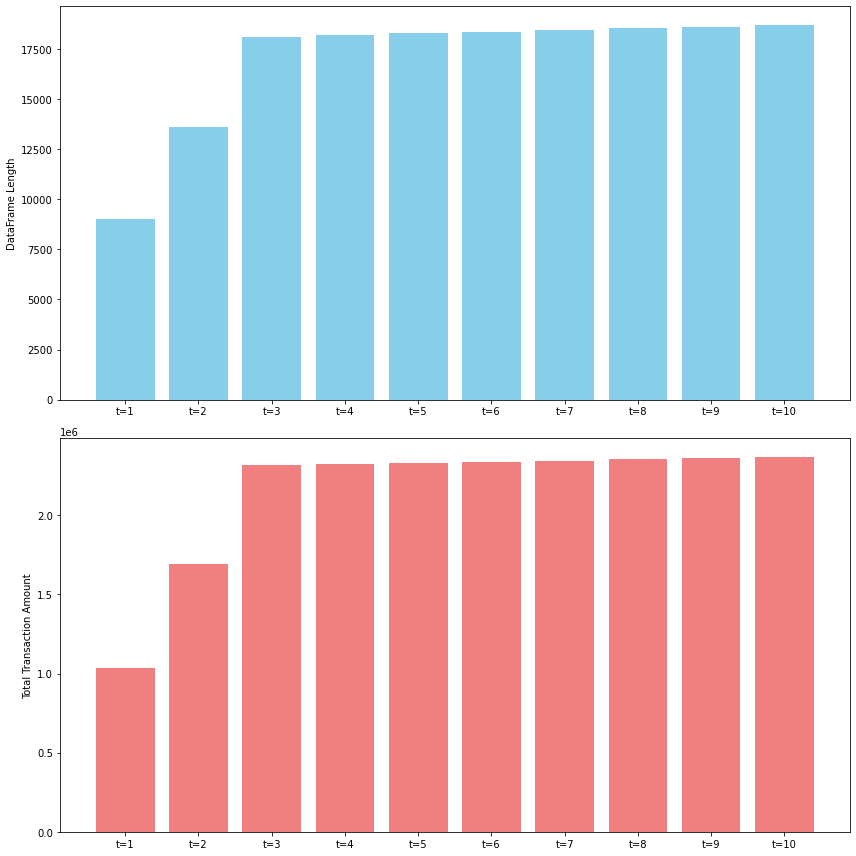

In [144]:
lengths = []
lengths += [len(multi_swipe_transactions_i) for multi_swipe_transactions_i in [multi_swipe_transactions_1, multi_swipe_transactions_2, multi_swipe_transactions_3, multi_swipe_transactions_4, multi_swipe_transactions_5, multi_swipe_transactions_6, multi_swipe_transactions_7, multi_swipe_transactions_8, multi_swipe_transactions_9, multi_swipe_transactions_10]]

# Calculate total transactionAmounts for each DataFrame
total_amounts = []
total_amounts += [multi_swipe_transactions_i['transactionAmount'].sum() for multi_swipe_transactions_i in [multi_swipe_transactions_1, multi_swipe_transactions_2, multi_swipe_transactions_3, multi_swipe_transactions_4, multi_swipe_transactions_5, multi_swipe_transactions_6, multi_swipe_transactions_7, multi_swipe_transactions_8, multi_swipe_transactions_9, multi_swipe_transactions_10]]

# Plot histograms
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot histogram for DataFrame lengths
ax[0].bar(range(10), lengths, color='skyblue')
ax[0].set_xticks(range(10))
ax[0].set_xticklabels([f't={i}' for i in range(1, 11)])
ax[0].set_ylabel('DataFrame Length')

# Plot histogram for total transactionAmounts
ax[1].bar(range(10), total_amounts, color='lightcoral')
ax[1].set_xticks(range(10))
ax[1].set_xticklabels([f't={i}' for i in range(1, 11)])
ax[1].set_ylabel('Total Transaction Amount')

# Adjust layout
plt.tight_layout()
plt.savefig('figs/multi_swipe_transactions.png')

In [145]:
print(total_amounts[2])
lengths[2]

2316914.42


18105

#### Based on the 2 histogram plots, we can see that timedifference of at most 3 minutes might be the best threshold to classify a transaction as multi-swipe transaction.

Based on that, we can see that 18,105 transactions were multi-swipe and the total amount was $2,316,914.42

In [146]:
print(len(df6))
# Merge the two DataFrames with an indicator column
merged_df = pd.merge(df6, multi_swipe_transactions_3, how='outer', indicator=True)

# Filter rows that are only in df6
df6_minus_multi_swipe_3 = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
print(len(df6_minus_multi_swipe_3))

717781
712790


#### We can see that removing the multiple swipes from the reversed transaction data of Method 2 reduces the dataframe's length from 717781 to 712790  

In [147]:
# Save the new DataFrame
df6_minus_multi_swipe_3.to_csv('data/transactions_processed_noreversed_method2_no_multi_swipe_3.csv', index=False)

In [148]:
print(len(df3))
# Merge the two DataFrames with an indicator column
merged_df = pd.merge(df3, multi_swipe_transactions_3, how='outer', indicator=True)

# Filter rows that are only in df6
df3_minus_multi_swipe_3 = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
print(len(df3_minus_multi_swipe_3))

781748
763688


In [149]:
# Save the new DataFrame
df3_minus_multi_swipe_3.to_csv('data/transactions_processed_noreversed_method1_no_multi_swipe_3.csv', index=False)

#### We can see that removing the multiple swipes from the reversed transaction data of Method 1 reduces the dataframe's length from 781748 to 763688  

In [150]:
# Identify pairs of PURCHASE and REVERSAL transactions
purchase_reversal_pairs = df[df.duplicated(subset=['customerId', 'transactionAmount', 'merchantName'], keep=False) &
                              ((df['transactionType'] == 'PURCHASE') | (df['transactionType'] == 'REVERSAL'))]

# Calculate the time difference in minutes
purchase_reversal_pairs['transactionDateTime'] = pd.to_datetime(purchase_reversal_pairs['transactionDateTime'])
purchase_reversal_pairs['timeDifferenceMinutes'] = purchase_reversal_pairs.groupby(['customerId', 'transactionAmount', 'merchantName'])['transactionDateTime'].diff().dt.total_seconds() / 60

<ipython-input-150-80bbb9feec08>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_reversal_pairs['transactionDateTime'] = pd.to_datetime(purchase_reversal_pairs['transactionDateTime'])
<ipython-input-150-80bbb9feec08>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_reversal_pairs['timeDifferenceMinutes'] = purchase_reversal_pairs.groupby(['customerId', 'transactionAmount', 'merchantName'])['transactionDateTime'].diff().dt.total_seconds() / 60


In [151]:
purchase_reversal_pairs['timeDifferenceMinutes'].mean()/60/24

22.24645246322771

# Finding Interesting stuff:
1. For multi-swipe transactions, I found that a 3 minute time difference threshold is pretty good to identify multi-swipe transactions.
2. On the other hand, reversed transactions typically take about 22 days and 6 hours on average